# Model parameter estimation for an irregularly-sampled, continuous-discrete (non-linear) dynamical system

We show how to use cd-dynamax to estimate the parameters of a continuous-discrete (non-linear) dynamical system



## Preliminaries

### Code Setup

In [1]:
# Main imports
import sys
from itertools import count

# Import jax and utils
from jax import numpy as jnp
from jax import vmap
import jax.random as jr
from jax import jit, vmap
import diffrax as dfx

# Additional, custom codebase
sys.path.append("../..")
sys.path.append("../../..")

# Our own custom src codebase
# continuous-discrete nonlinear Gaussian SSM codebase
from utils.plotting_utils import *
# CD-Nonlinear Gaussian models
from continuous_discrete_nonlinear_gaussian_ssm import ContDiscreteNonlinearGaussianSSM
from continuous_discrete_nonlinear_gaussian_ssm.models import *

# Useful utility functions
from simulation_utils import *

# Plotting
import matplotlib
%matplotlib inline
# Our own custom plotting codebase
from utils.plotting_utils import *
from lorenz_plotting import *
from parameter_learning_plotting import *
# Feel free to change the default figure size
#matplotlib.rcParams['figure.figsize'] = [16, 9]


/opt/homebrew/anaconda3/envs/hduq_nodynamax/lib/python3.11/site-packages/equinox/_ad.py:733: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(


# Generate synthetic data

We generate data from a Lorenz 63 system, from dynamics with the following stochastic differential equations:
\begin{align*}
\frac{d x}{d t} &= a(y-x) + \sigma w_x(t) \\
\frac{d y}{d t} &= x(b-z) - y + \sigma w_y(t) \\
\frac{d z}{d t} &= xy - cz + \sigma w_z(t),
\end{align*}

With parameters $a=10, b=28, c=8/3$, the system gives rise to chaotic behavior, and we choose $\sigma=0.1$ for light diffusion.

To generate data, we numerically approximate random path solutions to this SDE using Heun's method (i.e. improved Euler), as implemented in [Diffrax](https://docs.kidger.site/diffrax/api/solvers/sde_solvers/).


We assume the observation model is
\begin{align*}
y(t) &= H x(t) + r(t) \\
r(t) &\sim N(0,R),
\end{align*}
where we choose $R=I$. 

Namely, with H=I, we have full observability, with noisy observations, sampled at irregular time intervals.

### True, data-generating model definition

In [2]:
## Main settings
state_dim = 3
emission_dim = 1

# Define a custom drift model, inherited from LearnableFunction
class lorenz63_drift(LearnableFunction):
    params: Union[Float[Array, "state_dim"], ParameterProperties]

    def f(self, x, u=None, t=None):
        foo = jnp.array(
            [
                self.params[0] * (x[1] - x[0]),
                self.params[1] * x[0] - x[1] - x[0] * x[2],
                -self.params[2] * x[2] + x[0] * x[1],
            ]
        )
        return foo

# Define the true parameters of the drift function
true_l63_drift_params = jnp.array([10.0, 28.0, 8 / 3])
# And the corresponding Lorenz 63 system
true_drift = {
    "params": lorenz63_drift(
        params=true_l63_drift_params
    ),
    "props": lorenz63_drift(
        params=ParameterProperties()
    ),
}

# Define the true parameters of the diffusion function
true_diffusion_cov = {
    "params": LearnableMatrix(
        params=jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            constrainer=RealToPSDBijector()
        )
    ),
}

# Define the true parameters of the diffusion function
true_diffusion_coefficient_param = 0.1
true_diffusion_coefficient = {
    "params": LearnableMatrix(
        params=true_diffusion_coefficient_param * jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties()
    ),
}

# Define the true parameters of the emission function
# Full observability
H=jnp.eye(emission_dim,state_dim)
true_emission = {
    "params": LearnableLinear(
        weights=H,
        bias=jnp.zeros(emission_dim)
    ),
    "props": LearnableLinear(
        weights=ParameterProperties(),
        bias=ParameterProperties()
    ),
}

# Define the true parameters of the emission covariance
R=jnp.eye(emission_dim)
true_emission_cov = {
    "params": LearnableMatrix(
        params=R
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            constrainer=RealToPSDBijector()
        )
    ),
}

# Define the true initial mean and covariance
true_initial_mean = {
    "params": LearnableVector(
        params=jnp.zeros(state_dim)
    ),
    "props": LearnableVector(
        params=ParameterProperties()
    ),
}

true_initial_cov_param = 10.0
true_initial_cov = {
    "params": LearnableMatrix(
        params=true_initial_cov_param*jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            constrainer=RealToPSDBijector()
        )
    ),
}

# Concatenate all parameters in dictionary, for later easy use
all_true_params = {
    'initial_mean': true_initial_mean,
    'initial_cov': true_initial_cov,
    'dynamics_drift': true_drift,
    'dynamics_diffusion_coefficient': true_diffusion_coefficient,
    'dynamics_diffusion_cov': true_diffusion_cov,
    'dynamics_approx_order': 2., # Check on this later
    'emission_function': true_emission,
    'emission_cov': true_emission_cov,
}

### Simulation set-up

In [3]:
# Set up seed for simulation
keys = map(jr.PRNGKey, count())

# Simulation parameters
T_total = 50
T_filter = int(0.8*T_total)
num_timesteps_total = int(T_total/ 0.01)

# Generate time points for measurements, filtering and forecasting
# We will generate different train and test sets

## Train set
t_emissions_train, t_filter_train, t_forecast_train, \
    num_timesteps_train, num_timesteps_filter_train, num_timesteps_forecast_train= \
    generate_irregular_t_emissions(
        T_total=T_total,
        num_timesteps=num_timesteps_total,
        T_filter=T_filter,
        key=next(keys)
    )

## Test set
t_emissions_test, t_filter_test, t_forecast_test, \
    num_timesteps_test, num_timesteps_filter_test, num_timesteps_forecast_test= \
    generate_irregular_t_emissions(
        T_total=T_total,
        num_timesteps=num_timesteps_total,
        T_filter=T_filter,
        key=next(keys)
    )

### Model creation: object instantiation

In [4]:
hifi_forward_settings = {
    "solver": dfx.Heun(),
    "dt0": 1e-5,
    "stepsize_controller": dfx.ConstantStepSize(),
    # dfx.PIDController(atol=1e-9, rtol=1e-7, pcoeff=0.1, icoeff=0.3, dcoeff=0),
    "tol_vbt": 1e-5,
    "max_steps": 1e6,
}  # empty uses default settings


# Create CD-NLGSSM model
true_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim, diffeqsolve_settings=hifi_forward_settings)
true_params, _ = true_model.initialize(
    next(keys),
    **all_true_params
)

### Simulate data: sample from model

In [5]:
# sample true states and emissions from defined true model.
# Using transition_type="path" to solve the dynamics SDE.

## Train set
true_states_train, true_emissions_train = true_model.sample(
    true_params,
    next(keys),
    num_timesteps_train,
    t_emissions_train,
    transition_type="path" # uses the Euler-Maruyama method
)

## Test set
true_states_test, true_emissions_test = true_model.sample(
    true_params,
    next(keys),
    num_timesteps_test,
    t_emissions_test,
    transition_type="path" # uses the Euler-Maruyama method
)

Sampling from SDE solver path (this may be an unnecessarily poor approximation if you're simulating from a linear SDE). It is an appropriate choice for non-linear SDEs.
Sampling from SDE solver path (this may be an unnecessarily poor approximation if you're simulating from a linear SDE). It is an appropriate choice for non-linear SDEs.


### Plot generated data

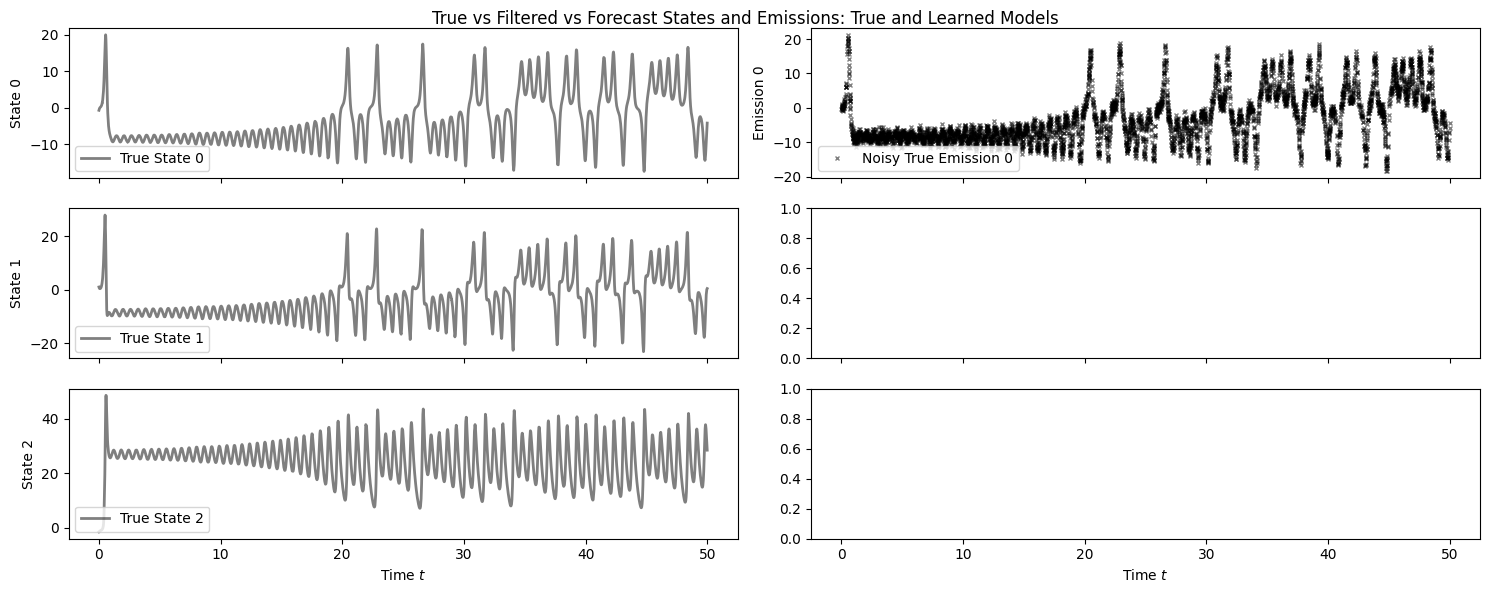

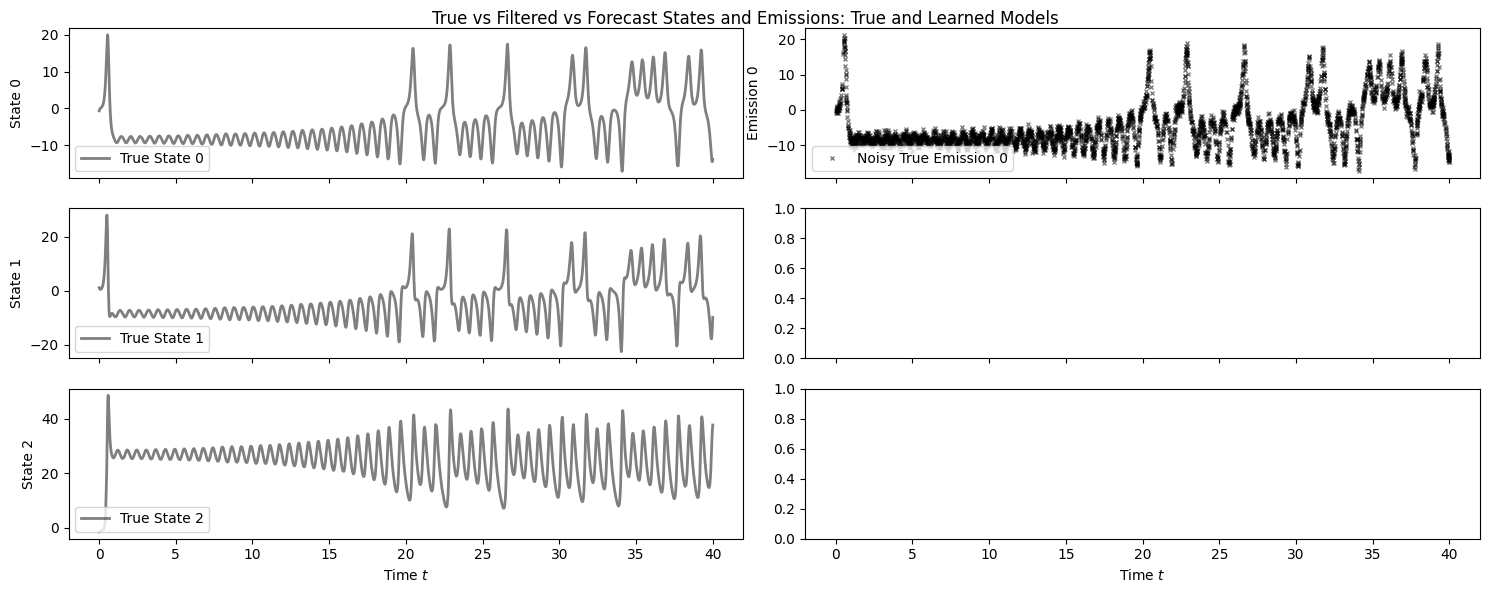

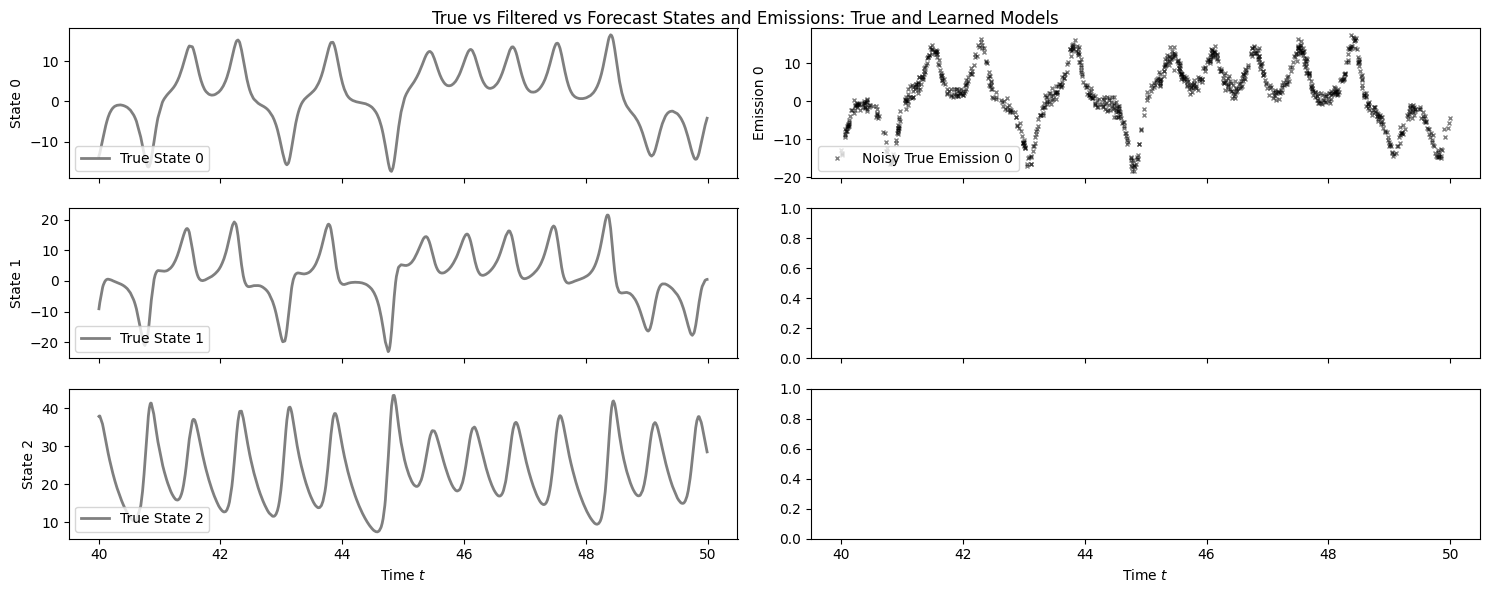

In [6]:
# Plot all the training data
plot_advanced2(
    time_grid_all=t_emissions_train,
    true_states=true_states_train,
    true_emissions_noisy=true_emissions_train,
    emission_function=true_params.emissions.emission_function
)

# Plot the filtering training data
plot_advanced2(
    time_grid_all=t_emissions_train,
    true_states=true_states_train,
    true_emissions_noisy=true_emissions_train,
    emission_function=true_params.emissions.emission_function,
    t_start=0,
    t_end=T_filter
)

# Plot the forecasting training data
plot_advanced2(
    time_grid_all=t_emissions_train,
    true_states=true_states_train,
    true_emissions_noisy=true_emissions_train,
    emission_function=true_params.emissions.emission_function,
    t_start=T_filter,
    t_end=T_total
)

# Parameter learning

### We start by defining a new model that is learnable

- We want to learn a model that might or might not be within the same function class of the data-generating mechanism

- The learnable model will be a ContDiscreteNonlinearGaussianSSM

- Here, we define the same model family as the data-generating model
    - i.e., the model family class is the same

- However:
    - the dynamics drift function will not-initialized to true values, and will be learnable
    - The rest of the model components will NOT be learnable

### CODE hint

- By default, all ParamProperties are set to trainable=True

- So, make sure you EXPLICITLY set trainable=False for all parameters you DO NOT want to learn/infer

In [7]:
## Main settings
state_dim = 3
emission_dim = 1

# The only learnable parameters are those in the learnable_drift
# do 50% relative perturbation of the true parameters
perturbation = jr.normal(next(keys), (len(true_l63_drift_params),))
drift_parameter_guess = true_l63_drift_params * (1.0 + 0.5 * perturbation)
# drift_parameter_guess = true_l63_drift_params + 0.1 * jr.normal(next(keys), (len(true_l63_drift_params),))

# Define the learnable drift model, with initial guess
learnable_drift = {
    "params": lorenz63_drift(params=drift_parameter_guess),
    "props": lorenz63_drift(params=ParameterProperties()),
}

## All parameters below are NOT learnable
learnable_diffusion_cov = {
    "params": LearnableMatrix(
        params=jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            trainable=False,
            constrainer=RealToPSDBijector()
        )
    ),
}

# The diffusion coefficient is fixed to non-learnable identity
learnable_diffusion_coefficient = {
    "params": LearnableMatrix(
        params=true_diffusion_coefficient_param * jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(trainable=False)
    ),
}

# The emission function is fixed to non-learnable identity
learnable_emission = {
    "params": LearnableLinear(
        weights=H,
        bias=jnp.zeros(emission_dim)
    ),
    "props": LearnableLinear(
        weights=ParameterProperties(trainable=False),
        bias=ParameterProperties(trainable=False)
    ),
}

# The emission covariance is fixed to non-learnable identity
learnable_emission_cov = {
    "params": LearnableMatrix(
        params=R
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            trainable=False,
            constrainer=RealToPSDBijector()
        )
    ),
}

# Define the initial mean and covariance
learnable_initial_mean = {
    "params": LearnableVector(
        params=jnp.zeros(state_dim)
    ),
    "props": LearnableVector(
        params=ParameterProperties(trainable=False)
    ),
}

learnable_initial_cov = {
    "params": LearnableMatrix(
        params=10.0 * jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(params=ParameterProperties(trainable=False, constrainer=RealToPSDBijector())),
}

# Concatenate all parameters in dictionary, for later easy use
all_learnable_params = {
    "initial_mean": learnable_initial_mean,
    "initial_cov": learnable_initial_cov,
    "dynamics_drift": learnable_drift,
    "dynamics_diffusion_coefficient": learnable_diffusion_coefficient,
    "dynamics_diffusion_cov": learnable_diffusion_cov,
    "dynamics_approx_order": 2.,  # Check on this later
    "emission_function": learnable_emission,
    "emission_cov": learnable_emission_cov,
}

### Define, instantiate and initialize the learnable model

In [8]:
# Create CD-NLGSSM model
learnable_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim)
initial_learnable_params, learnable_props = learnable_model.initialize(
    next(keys),
    **all_learnable_params
)

# Frequentist parameter estimation: Maximum likelihood estimates MLE


## Maximum likelihood parameter estimation for an irregularly-sampled, continuous-discrete (non-linear) Gaussian dynamical system

- MLE based on SGD over marginalized log-probability
- We will use Extended Kalman Filtering to compute the marginal log probability
    - Note that other options (EnKF and UKF) are implemented and can be readily used

### Define the filter to use to compute the marginalized log-likelihood

In [9]:
# Filter: EKF
from continuous_discrete_nonlinear_gaussian_ssm import EKFHyperParams
# filter_hyperparams = EKFHyperParams(diffeqsolve_settings={"max_steps": 1e5, "solver": dfx.Tsit5()}) #, state_order="zeroth")
filter_hyperparams = EKFHyperParams(
    diffeqsolve_settings={"max_steps": 1e2},
    # state_order="zeroth"
    # "solver": dfx.Dopri5()}
)  # , state_order="zeroth")

### Define the SGD optimizer to use

In [10]:
import optax

num_epochs = 2000

# define a learning rate scheduler
initial_learning_rate = 1e-1
decay_factor = 0.5  # Decay the learning rate by a factor
epochs_per_step = 400  # Number of epochs per decay step

# Define the boundaries where the decay should happen
# In this case, every 20 epochs
boundaries = [epochs_per_step * i for i in range(1, num_epochs // epochs_per_step + 1)]

# Define the values of the learning rates at each boundary
values = [initial_learning_rate * (decay_factor**i) for i in range(len(boundaries) + 1)]

# Create a step decay learning rate schedule
scheduler = optax.piecewise_constant_schedule(
    init_value=initial_learning_rate, boundaries_and_scales={boundary: decay_factor for boundary in boundaries}
)

# define an optimizer with a learning rate of 1e-1 and gradient clipping
my_optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.scale_by_adam(),
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    optax.scale(-1.0),
)

### Fit the learnable model, using SGD to observed data, using the EKF filter to marginalize the latent states

In [11]:
# Fit test_model by running SGD, with EKF filter
fitted_params, neg_marginal_lls, param_history, grad_history = learnable_model.fit_sgd(
    initial_learnable_params,
    learnable_props,
    true_emissions_train,
    t_emissions=t_emissions_train,
    filter_hyperparams=filter_hyperparams,
    optimizer=my_optimizer,
    num_epochs=num_epochs,
    return_grad_history=True,
    return_param_history=True,
)

# Note that fit_sgd returns normalized negative log-likelihoods
# So we multiply it by the number of datapoints in emissions
marginal_lls = -neg_marginal_lls * true_emissions_train.size

### Visualize learning: marginal log-likelihood evolution

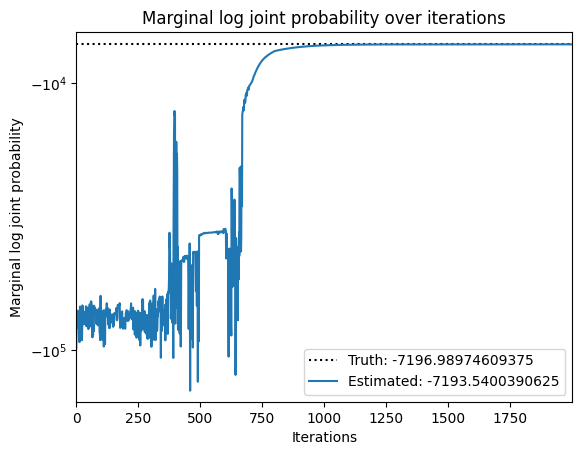

In [12]:
plot_mll_learning_curve(
    true_model,
    true_params,
    true_emissions_train,
    t_emissions_train,
    marginal_lls,
)

## Evaluate learned MLE model

### Filter and forecast, using the fitted parameters and an EKF filter

In [13]:
# Define filter and forecast time points
T0 = 5 # Ignore initial transient
T_filter_end = 25 # End of filtering
T_forecast_end = 45 # End of forecasting

### Run EKF filtering on training data using learned MLE model

In [14]:
# Filter and forecast, using the fitted parameters and an EKF filter, on training data
filtered_trainset_sgd, forecasted_trainset_sgd, \
    start_idx_filter, stop_idx_filter, \
        start_idx_forecast, stop_idx_forecast = \
            filter_and_forecast(
                model_params=fitted_params,
                filter_hyperparams=filter_hyperparams,
                t_emissions=t_emissions_train,
                emissions=true_emissions_train,
                T0=T0,
                T_filter_end=T_filter_end,
                T_forecast_end=T_forecast_end,
            )

### Plot performance of filtering and forecasting on training data

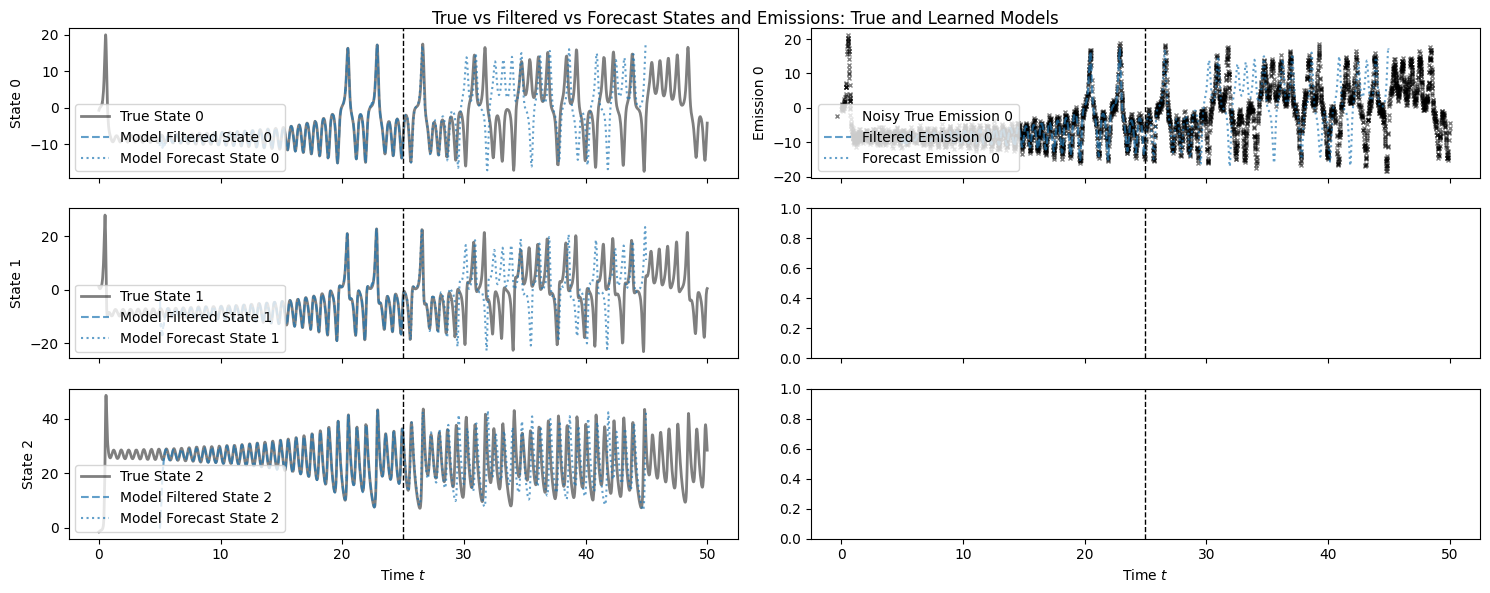

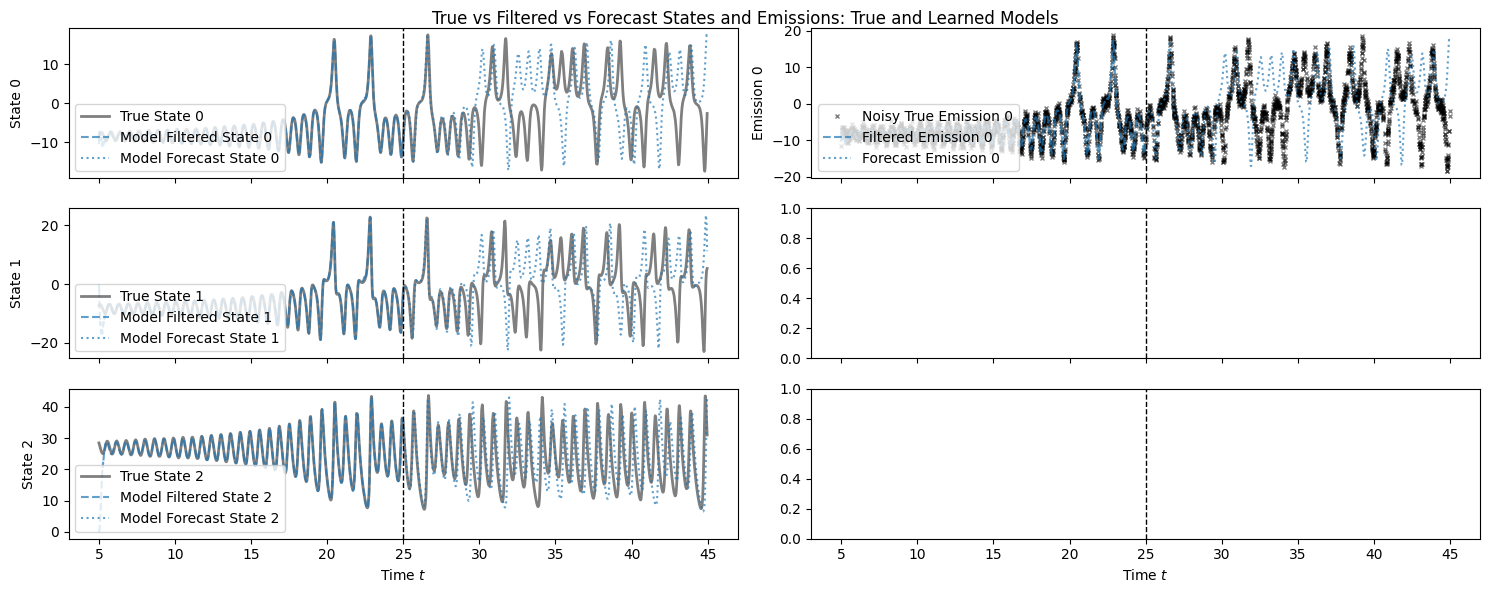

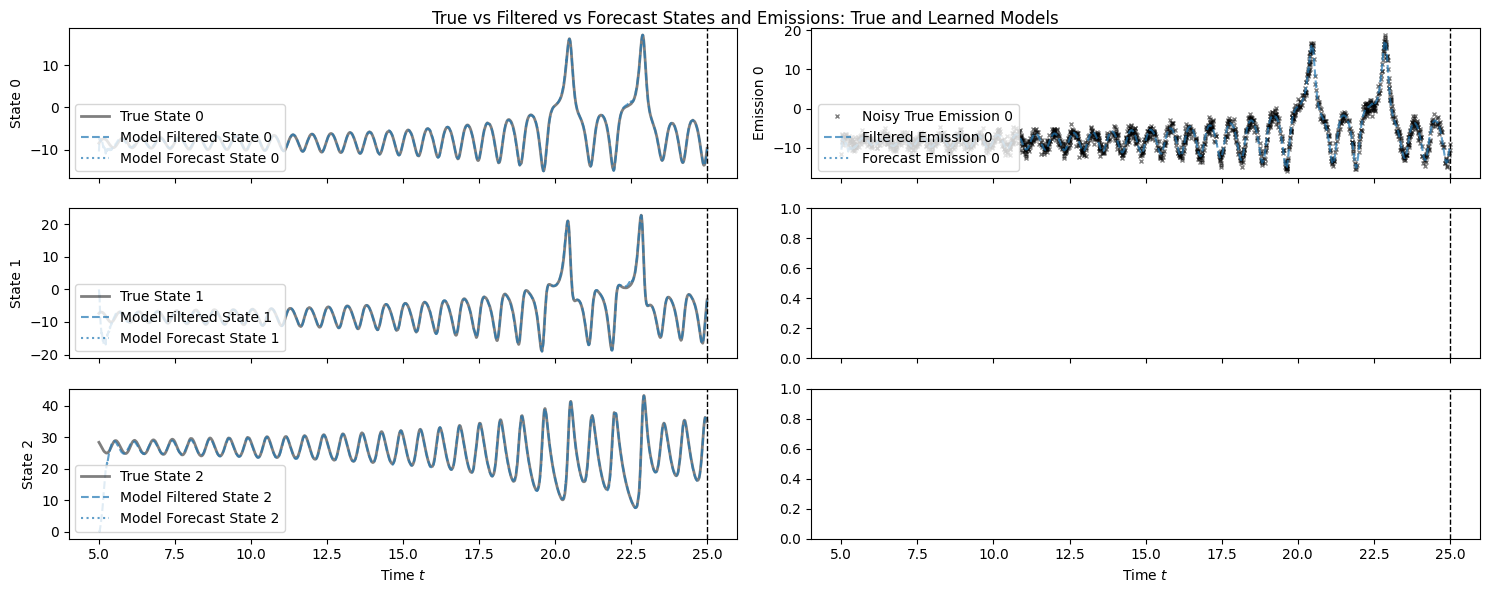

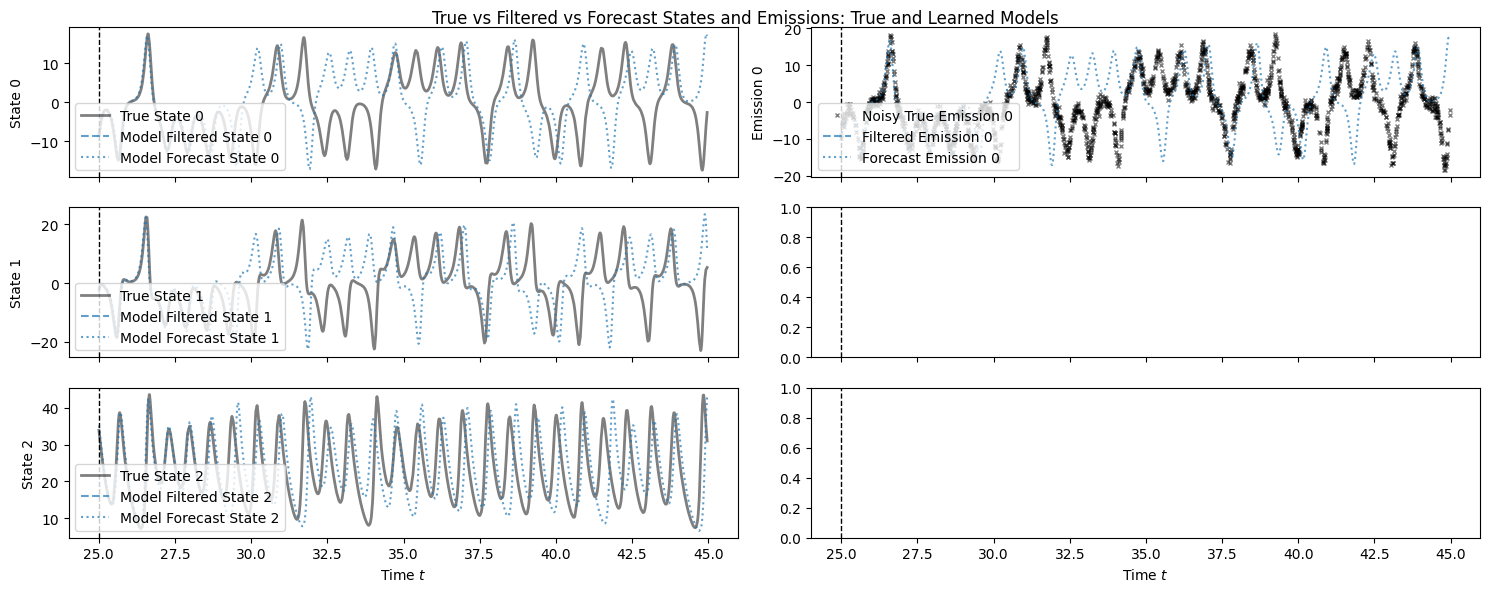

In [15]:
# Plot the true states and emissions, and the EKF estimates
for t_start, t_end in [
        (None, None), # Plot all
        (T0, T_forecast_end), # Plot from T0 until T_forecast_end, i.e., filtering and forecasting
        (T0, T_filter_end), # Plot from T0 until T_forecast_end, i.e., filtering
        (T_filter_end, T_forecast_end) # Plot from T_filter_end until T_forecast_end, i.e., forecasting
    ]:
    plot_advanced2(
        time_grid_all=t_emissions_train,
        true_states=true_states_train,
        true_emissions_noisy=true_emissions_train,
        emission_function=fitted_params.emissions.emission_function.f,
        time_grid_filter=t_emissions_train[start_idx_filter:stop_idx_filter],
        model_filtered_states=filtered_trainset_sgd.filtered_means,
        time_grid_forecast=t_emissions_train[start_idx_forecast:stop_idx_forecast],
        model_forecast_states=forecasted_trainset_sgd.forecasted_state_means,
        t_start=t_start,
        t_end=t_end,
    )

### Run EKF filtering on testing data using learned MLE model

In [16]:
# Filter and forecast, using the fitted parameters and an EKF filter, on test data
filtered_testset_sgd, forecasted_testset_sgd, \
    start_idx_filter, stop_idx_filter, \
        start_idx_forecast, stop_idx_forecast = \
            filter_and_forecast(
                model_params=fitted_params,
                filter_hyperparams=filter_hyperparams,
                t_emissions=t_emissions_test,
                emissions=true_emissions_test,
                T0=T0,
                T_filter_end=T_filter_end,
                T_forecast_end=T_forecast_end,
            )

### Plot performance of filtering and forecasting on testing data

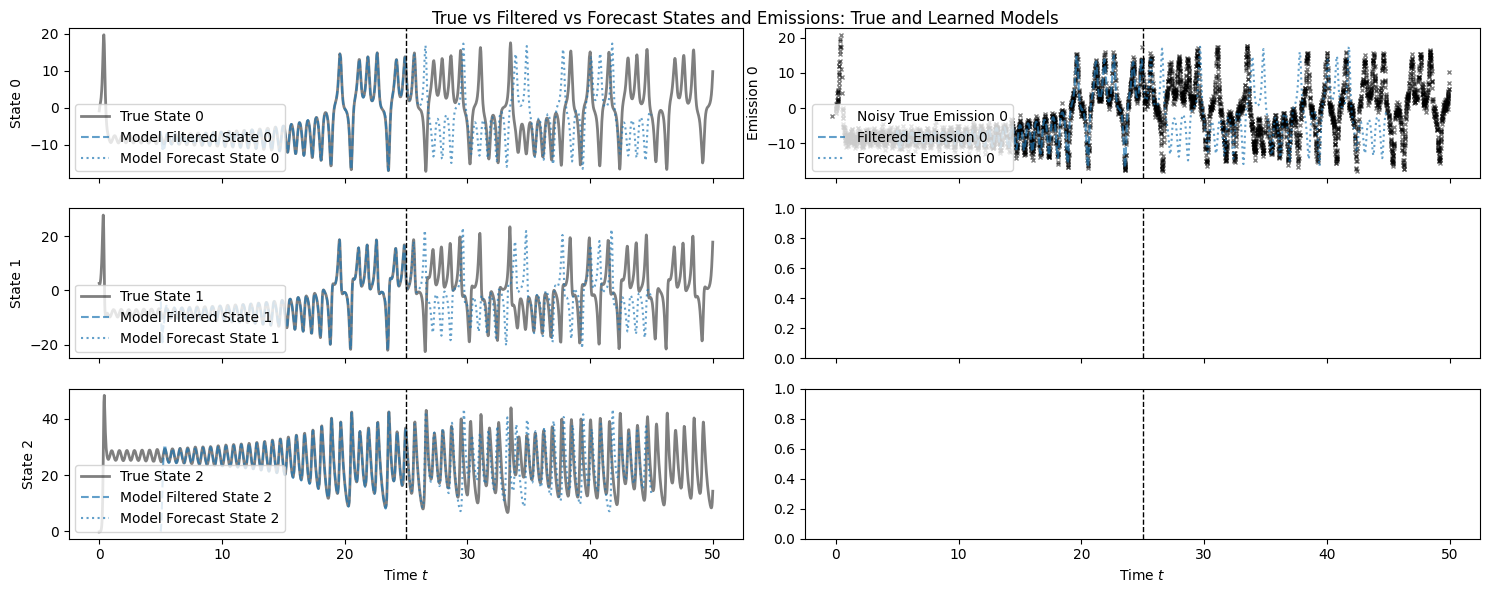

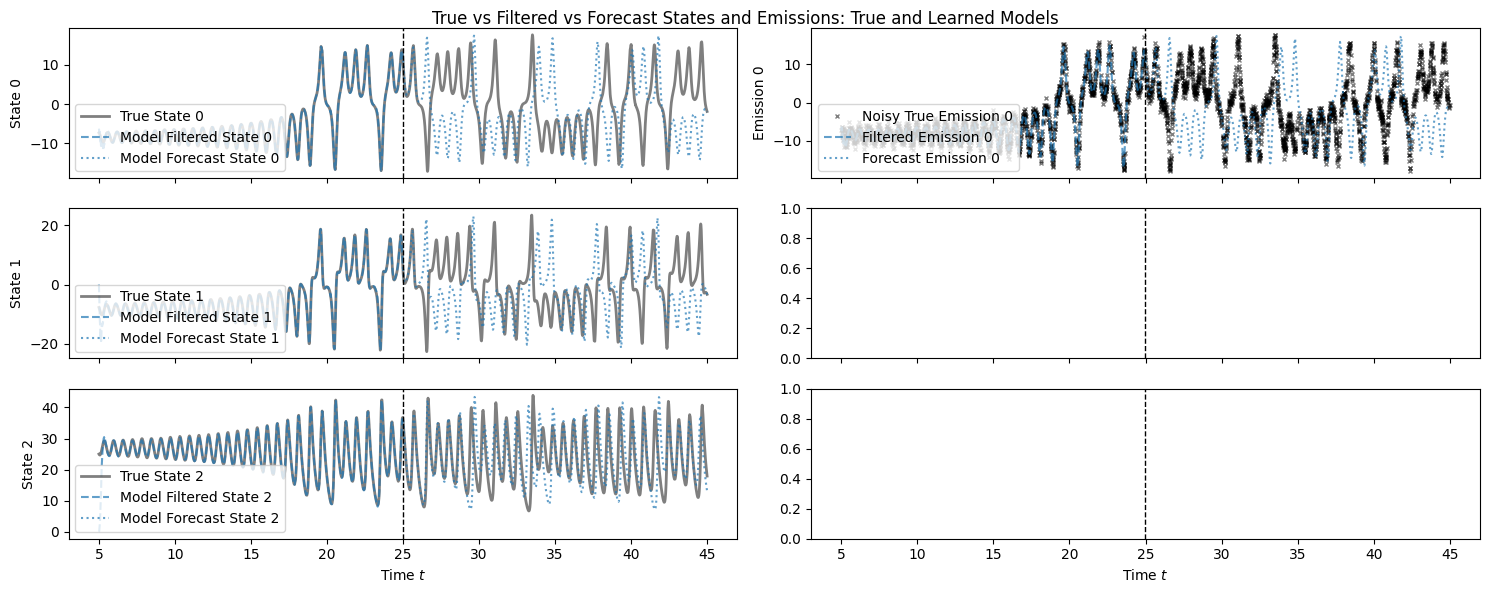

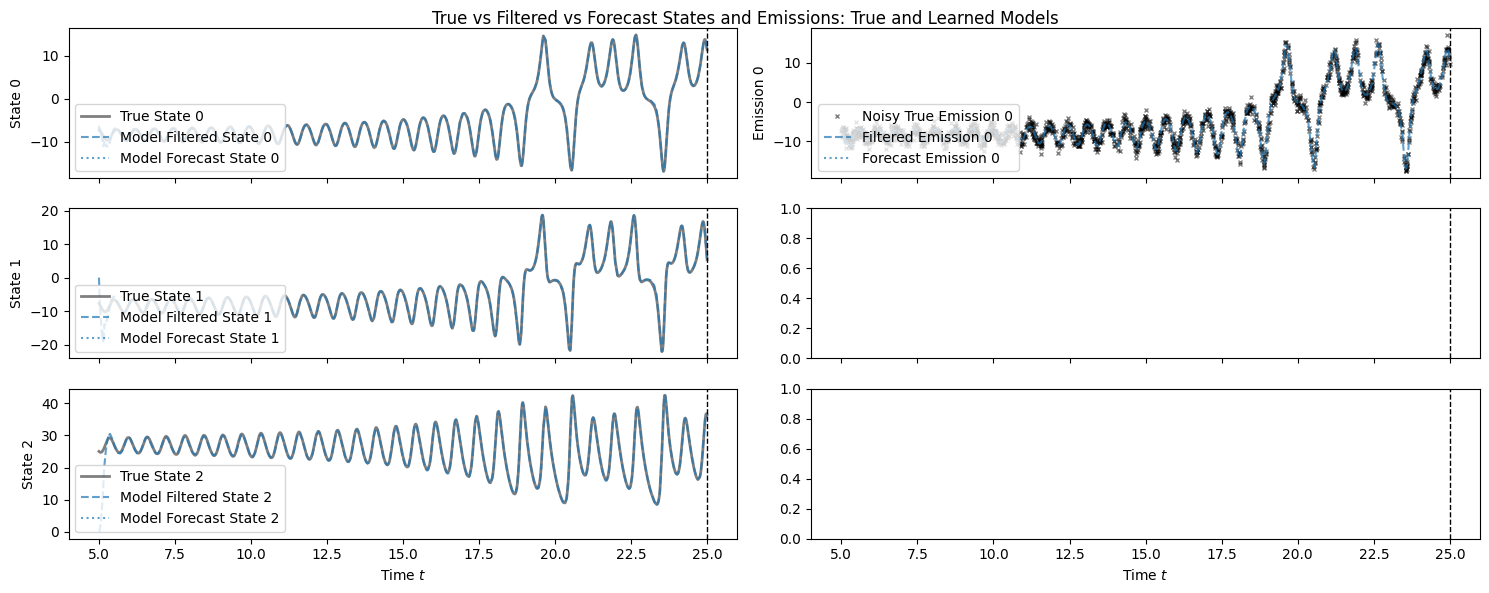

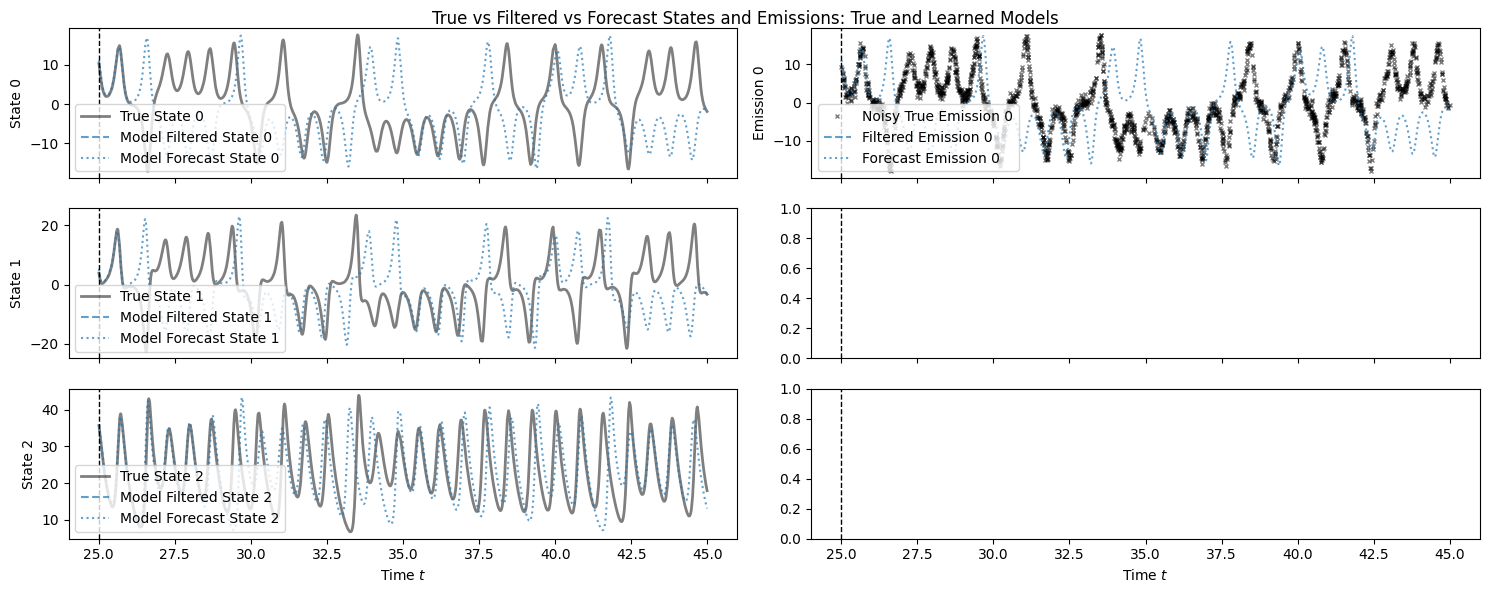

In [17]:
# Plot the true states and emissions, and the EKF estimates
for t_start, t_end in [
        (None, None), # Plot all
        (T0, T_forecast_end), # Plot from T0 until T_forecast_end, i.e., filtering and forecasting
        (T0, T_filter_end), # Plot from T0 until T_forecast_end, i.e., filtering
        (T_filter_end, T_forecast_end) # Plot from T_filter_end until T_forecast_end, i.e., forecasting
    ]:
    plot_advanced2(
        time_grid_all=t_emissions_test,
        true_states=true_states_test,
        true_emissions_noisy=true_emissions_test,
        emission_function=fitted_params.emissions.emission_function.f,
        time_grid_filter=t_emissions_test[start_idx_filter:stop_idx_filter],
        model_filtered_states=filtered_testset_sgd.filtered_means,
        time_grid_forecast=t_emissions_test[start_idx_forecast:stop_idx_forecast],
        model_forecast_states=forecasted_testset_sgd.forecasted_state_means,
        t_start=t_start,
        t_end=t_end,
    )

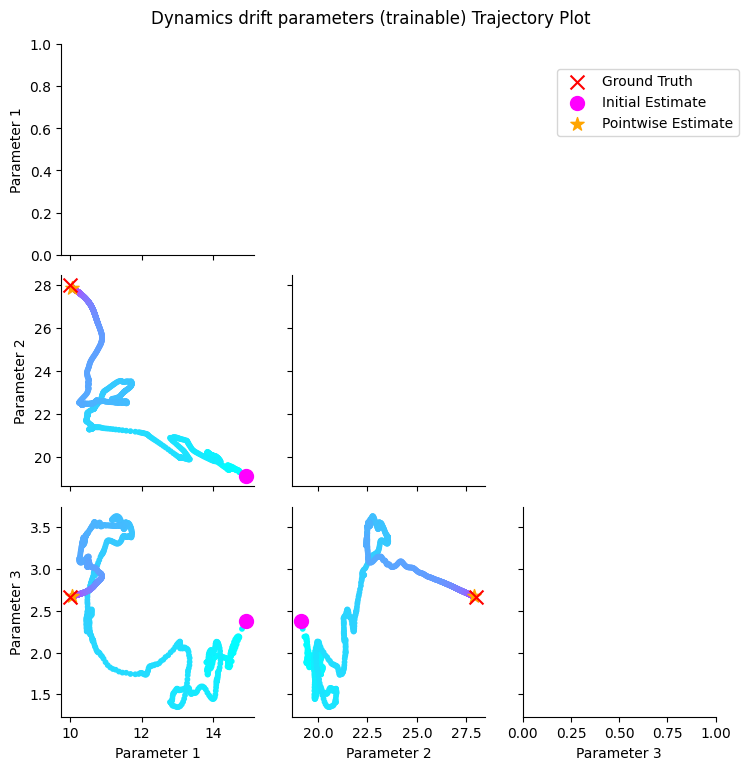

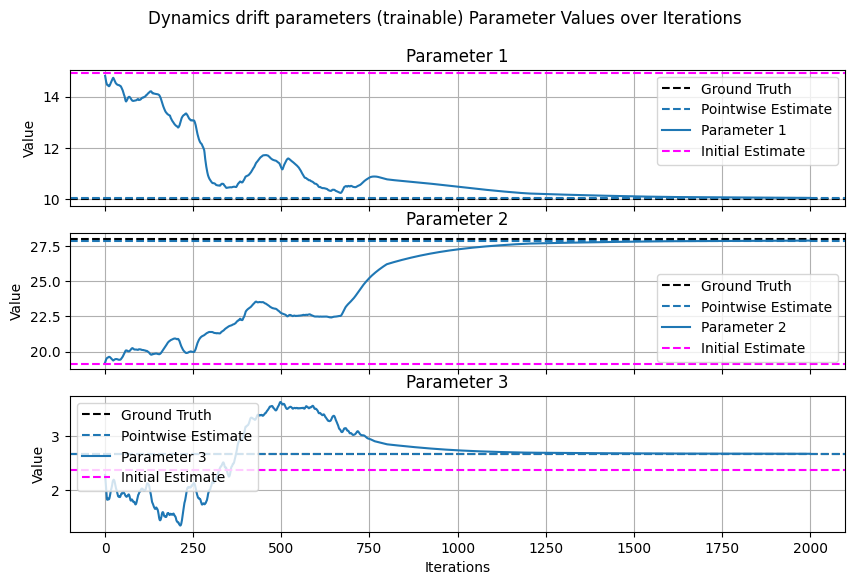

In [18]:
# omit initial params for easy viewing of region of high probability
plot_all_cdnlgssm_param_posteriors(
    param_samples=param_history,
    param_properties=learnable_props,
    init_params=initial_learnable_params,
    true_params=true_params,
    pointwise_estimate=fitted_params,
    triangle_plot=False,
    box_plot=False,
    burn_in_frac=0.0,
)